## **Disclaimer!**
This notebook is meant to be used by anyone interested in replicating our model or playing around with the data. In order to access all features, please go to this [Google Drive Folder](https://drive.google.com/drive/folders/1kUTkGI89PJRl0dVy79xIZuH9Qokl9Stq) and store it on your own Google Drive. By clicking on the folder name "Thesis_LucaThoms" and selecting "Add a shortcut to Drive", all necessary files are automatically shared with your main Drive environment without having to download all the data or files individually! After that, simply run all the code as you like.

In [ ]:
import os
import json
import random
import time
import cv2
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from keras.utils import to_categorical
from matplotlib import colors
from google.colab import drive

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Define directory to access image folders, labels, and pre-trained models
drive.mount('/content/drive', force_remount = True)
our_data_dir = '/content/drive/MyDrive/Thesis_LucaThoms/'

Mounted at /content/drive


## **Helper Functions**

In [ ]:
def plot_one(task, ax, i, train_or_test, input_or_output):
    cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    if input_or_output == 'prediction':
        input_matrix = test_predictions[i]
    else:
        input_matrix = task[train_or_test][i][input_or_output]

    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' ' + input_or_output)

def plot_task(task, idx):   
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i], i, 'train', 'input')
        plot_one(task, axs[1,i], i, 'train', 'output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    num_outp = len(task['test'][0])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test == 1: 
        plot_one(task, axs[0], 0, 'test', 'input')
        if num_outp > 1:
            plot_one(task, axs[1], 0, 'test', 'output')  
        elif 'test_predictions' in locals() or 'test_predictions' in globals():
            plot_one(task, axs[1], idx, 'test', 'prediction')
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i], i, 'test', 'input')
            plot_one(task, axs[1,i], i, 'test', 'output')  
    plt.tight_layout()
    plt.show() 


def plot_ARC(example_num = None, path = 'training'):
    idx = random.randint(0, 99) if example_num is None else example_num

    task_file = f'{eval(path + "_path")}{(eval(path + "_tasks_files"))[idx]}'
    with open(task_file, 'r') as f:
        example = json.load(f)

    plot_task(example, idx)

In [ ]:
def replace_values(a, d):
    return np.array([d.get(i, -1) for i in range(a.min(), a.max() + 1)])[a - a.min()]

def repeat_matrix(a):
    return np.concatenate([a]*((1000 // len(a)) + 1))[:1000]

def get_new_matrix(X):
    if len(set([np.array(x).shape for x in X])) > 1:
        X = np.array([X[0]])
    return X

def get_outp(outp, dictionary=None, replace=True):
    if replace:
        outp = replace_values(outp, dictionary)

    outp_matrix_dims = outp.shape
    outp_probs_len = outp.shape[0]*outp.shape[1]*10
    outp = to_categorical(outp.flatten(),
                          num_classes=10).flatten()

    return outp, outp_probs_len, outp_matrix_dims

In [ ]:
# Transformation / Resizing still in works!
def transform_dim(inp_dim, outp_dim, test_dim):
    return (test_dim[0]*outp_dim[0]/inp_dim[0],
            test_dim[1]*outp_dim[1]/inp_dim[1])

def resize(x, test_dim, inp_dim):
    if inp_dim == test_dim:
        return x
    else:
        return cv2.resize(flt(x), inp_dim, interpolation=cv2.INTER_AREA)

def flt(x): return np.float32(x)
def npy(x): return x.cpu().detach().numpy()
def itg(x): return np.int32(np.round(x))

## **Exploration**

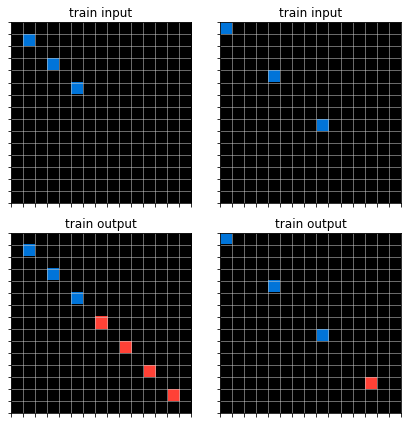

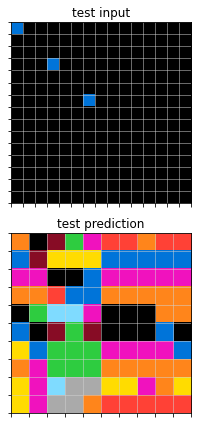

In [ ]:
plot_ARC(13, path = "test")

In [ ]:
training_path = f'{our_data_dir}Data/data_training/'
evaluation_path = f'{our_data_dir}Data/data_evaluation/'
test_path = f'{our_data_dir}Data/data_test/'

training_tasks_files = sorted(os.listdir(training_path))
evaluation_tasks_files = sorted(os.listdir(evaluation_path))
test_tasks_files = sorted(os.listdir(test_path))

In [ ]:
training_tasks = []
for task_file in training_tasks_files:
    with open(f'{training_path}{task_file}', 'r') as f:
        task = json.load(f)
        training_tasks.append(task)

# Example
training_tasks[55]["test"][3]["input"]

[[2, 0, 2], [0, 2, 0], [2, 0, 2]]

In [ ]:
X_test, X_train, y_train = [], [], []

for task in training_tasks:
    Xs_test, Xs_train, ys_train = [], [], []

    for pair in task["test"]:
        Xs_test.append(pair["input"])

    for pair in task["train"]:
        Xs_train.append(pair["input"])
        ys_train.append(pair["output"])
    
    X_test.append(Xs_test)
    X_train.append(Xs_train)
    y_train.append(ys_train)

matrices = []
for Xs_test in X_test:
    for X in Xs_test:
        matrices.append(X)

# Example
X_test[2]

[[[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 1], [0, 1, 0], [1, 1, 0]],
 [[0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1]],
 [[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 0], [1, 1, 0], [0, 1, 0]]]

In [ ]:
means = [np.mean(matrix) for matrix in matrices]
fig = ff.create_distplot([means], group_labels=["Means"], colors=["green"])
fig.update_layout(title_text="Distribution of matrix mean values")

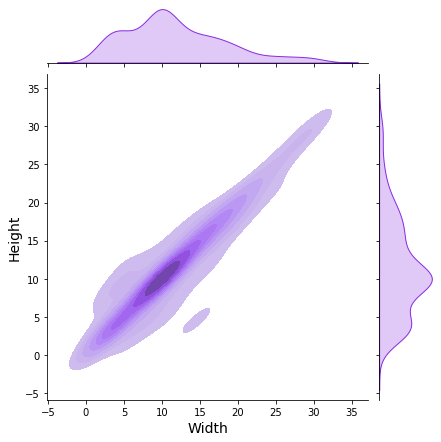

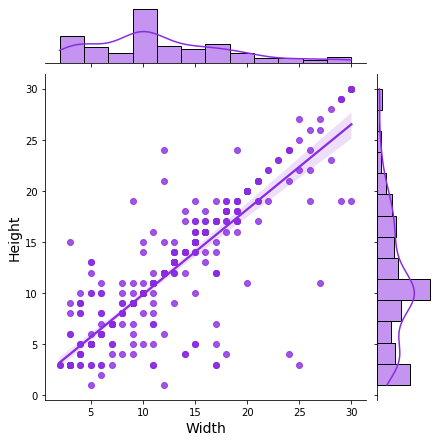

In [ ]:
heights = [np.shape(matrix)[0] for matrix in matrices]
widths = [np.shape(matrix)[1] for matrix in matrices]

plot = sns.jointplot(x=widths, y=heights, kind="kde", fill=True, thresh = 0.11, color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

plot = sns.jointplot(x=widths, y=heights, kind="reg", color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

## **Training**

In [ ]:
class ARCDataset(Dataset):
    def __init__(self, X, y, stage="train"):
        self.X = get_new_matrix(X)
        self.X = repeat_matrix(self.X)
        
        self.stage = stage
        if self.stage == "train":
            self.y = get_new_matrix(y)
            self.y = repeat_matrix(self.y)
        
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        inp = self.X[idx]
        if self.stage == "train":
            outp = self.y[idx]

        if idx != 0:
            rep = np.arange(10)
            orig = np.arange(10)
            np.random.shuffle(rep)
            dictionary = dict(zip(orig, rep))
            inp = replace_values(inp, dictionary)
            if self.stage == "train":
                outp, outp_probs_len, outp_matrix_dims = get_outp(outp, dictionary)
                
        if idx == 0:
            if self.stage == "train":
                outp, outp_probs_len, outp_matrix_dims = get_outp(outp, None, False)
        
        return inp, outp, outp_probs_len, outp_matrix_dims, self.y

In [ ]:
class BasicCNNModel(nn.Module):
    def __init__(self, inp_dim=(10, 10), outp_dim=(10, 10)):
        super(BasicCNNModel, self).__init__()
        
        Conv_In = 3
        Conv_Out_1 = 50
        Conv_Out_2 = 100
        Kernel = 3
        Dense_In = Conv_Out_2
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dense_1 = nn.Linear(Dense_In, outp_dim[0]*outp_dim[1]*10)
        
        if inp_dim[0] < 5 or inp_dim[1] < 5:
            Kernel = 1

        self.conv2d_1 = nn.Conv2d(Conv_In, Conv_Out_1, kernel_size=Kernel)
        self.conv2d_2 = nn.Conv2d(Conv_Out_1, Conv_Out_2, kernel_size=Kernel)

    def forward(self, x, outp_dim):
        x = torch.cat([x.unsqueeze(0)]*3)
        x = x.permute((1, 0, 2, 3)).float()
        self.conv2d_1.in_features = x.shape[1]
        conv_1_out = self.relu(self.conv2d_1(x))
        self.conv2d_2.in_features = conv_1_out.shape[1]
        conv_2_out = self.relu(self.conv2d_2(conv_1_out))
        
        self.dense_1.out_features = outp_dim
        feature_vector, _ = torch.max(conv_2_out, 2)
        feature_vector, _ = torch.max(feature_vector, 2)
        logit_outputs = self.dense_1(feature_vector)
        
        out = []
        for idx in range(logit_outputs.shape[1]//10):
            out.append(self.softmax(logit_outputs[:, idx*10: (idx+1)*10]))
        return torch.cat(out, axis=1)

In [ ]:
Batch_Size = 128
Epochs = 50

idx = 0
start = time.time()
test_predictions = []

for Xs_train, ys_train in zip(X_train, y_train):
    print("TASK " + str(idx + 1))

    train_set = ARCDataset(Xs_train, ys_train, stage="train")
    train_loader = DataLoader(train_set, batch_size=Batch_Size, shuffle=True)

    inp_dim = np.array(Xs_train[0]).shape
    outp_dim = np.array(ys_train[0]).shape
    network = BasicCNNModel(inp_dim, outp_dim).cuda()
    optimizer = Adam(network.parameters(), lr=0.01)
    
    for epoch in range(Epochs):
        for train_batch in train_loader:
            train_X, train_y, out_d, d, out = train_batch
            train_preds = network.forward(train_X.cuda(), out_d.cuda())
            train_loss = nn.MSELoss()(train_preds, train_y.cuda())
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

    end = time.time()        
    print("Train loss: " + str(np.round(train_loss.item(), 3)) + "   " +\
          "Total time: " + str(np.round(end - start, 1)) + " s" + "\n")
    
    Xs_test = np.array([resize(flt(X), np.shape(X), inp_dim) for X in X_test[idx-1]])
    for X in Xs_test:
        test_dim = np.array(torch.Tensor(X)).shape
        test_preds = npy(network.forward(torch.Tensor(X).unsqueeze(0).cuda(), out_d.cuda()))
        test_preds = np.argmax(test_preds.reshape((10, *outp_dim)), axis=0)
        test_predictions.append(itg(resize(test_preds, np.shape(test_preds),
                                           tuple(itg(transform_dim(inp_dim, outp_dim, test_dim))))))
    idx += 1

In [ ]:
# Saving predictions
# with open('example_pred.pkl', 'wb') as f:
#   pickle.dump(test_predictions, f)

# Loading saved predictions
with open('/content/drive/MyDrive/Thesis_LucaThoms/example_pred.pkl', 'rb') as f:
    test_predictions = pickle.load(f)
